In [2]:
import json

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

sns.set()

In [4]:
import os
print(os.path.join(os.path.dirname(__file__))) 

NameError: name '__file__' is not defined

In [5]:
with open('../phystech/data/contest_input.json', 'r') as f:
    data = json.load(f)

In [6]:
couriers = pd.DataFrame(data['couriers'])
depots = pd.DataFrame(data['depots'])
orders = pd.DataFrame(data['orders'])

In [7]:
orders = orders[orders['payment'] > 0]

In [8]:
couriers.head()

,courier_id,location_x,location_y
0,1,111,5
1,2,260,112
2,3,207,66
3,4,288,55
4,5,253,234


In [10]:
def plot_data(couriers, depots, orders):
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.scatter(x=couriers['location_x'], y=couriers['location_y'], marker='o', color='black', s=50)
    ax.scatter(x=orders['pickup_location_x'], y=orders['pickup_location_y'], marker='>', color='green', alpha=0.5, s=5)
    ax.scatter(x=orders['dropoff_location_x'], y=orders['dropoff_location_y'], marker='s', color='red', alpha=0.5, s=5)
    ax.scatter(x=depots['location_x'], y=depots['location_y'], marker='^', color='blue', s=300)

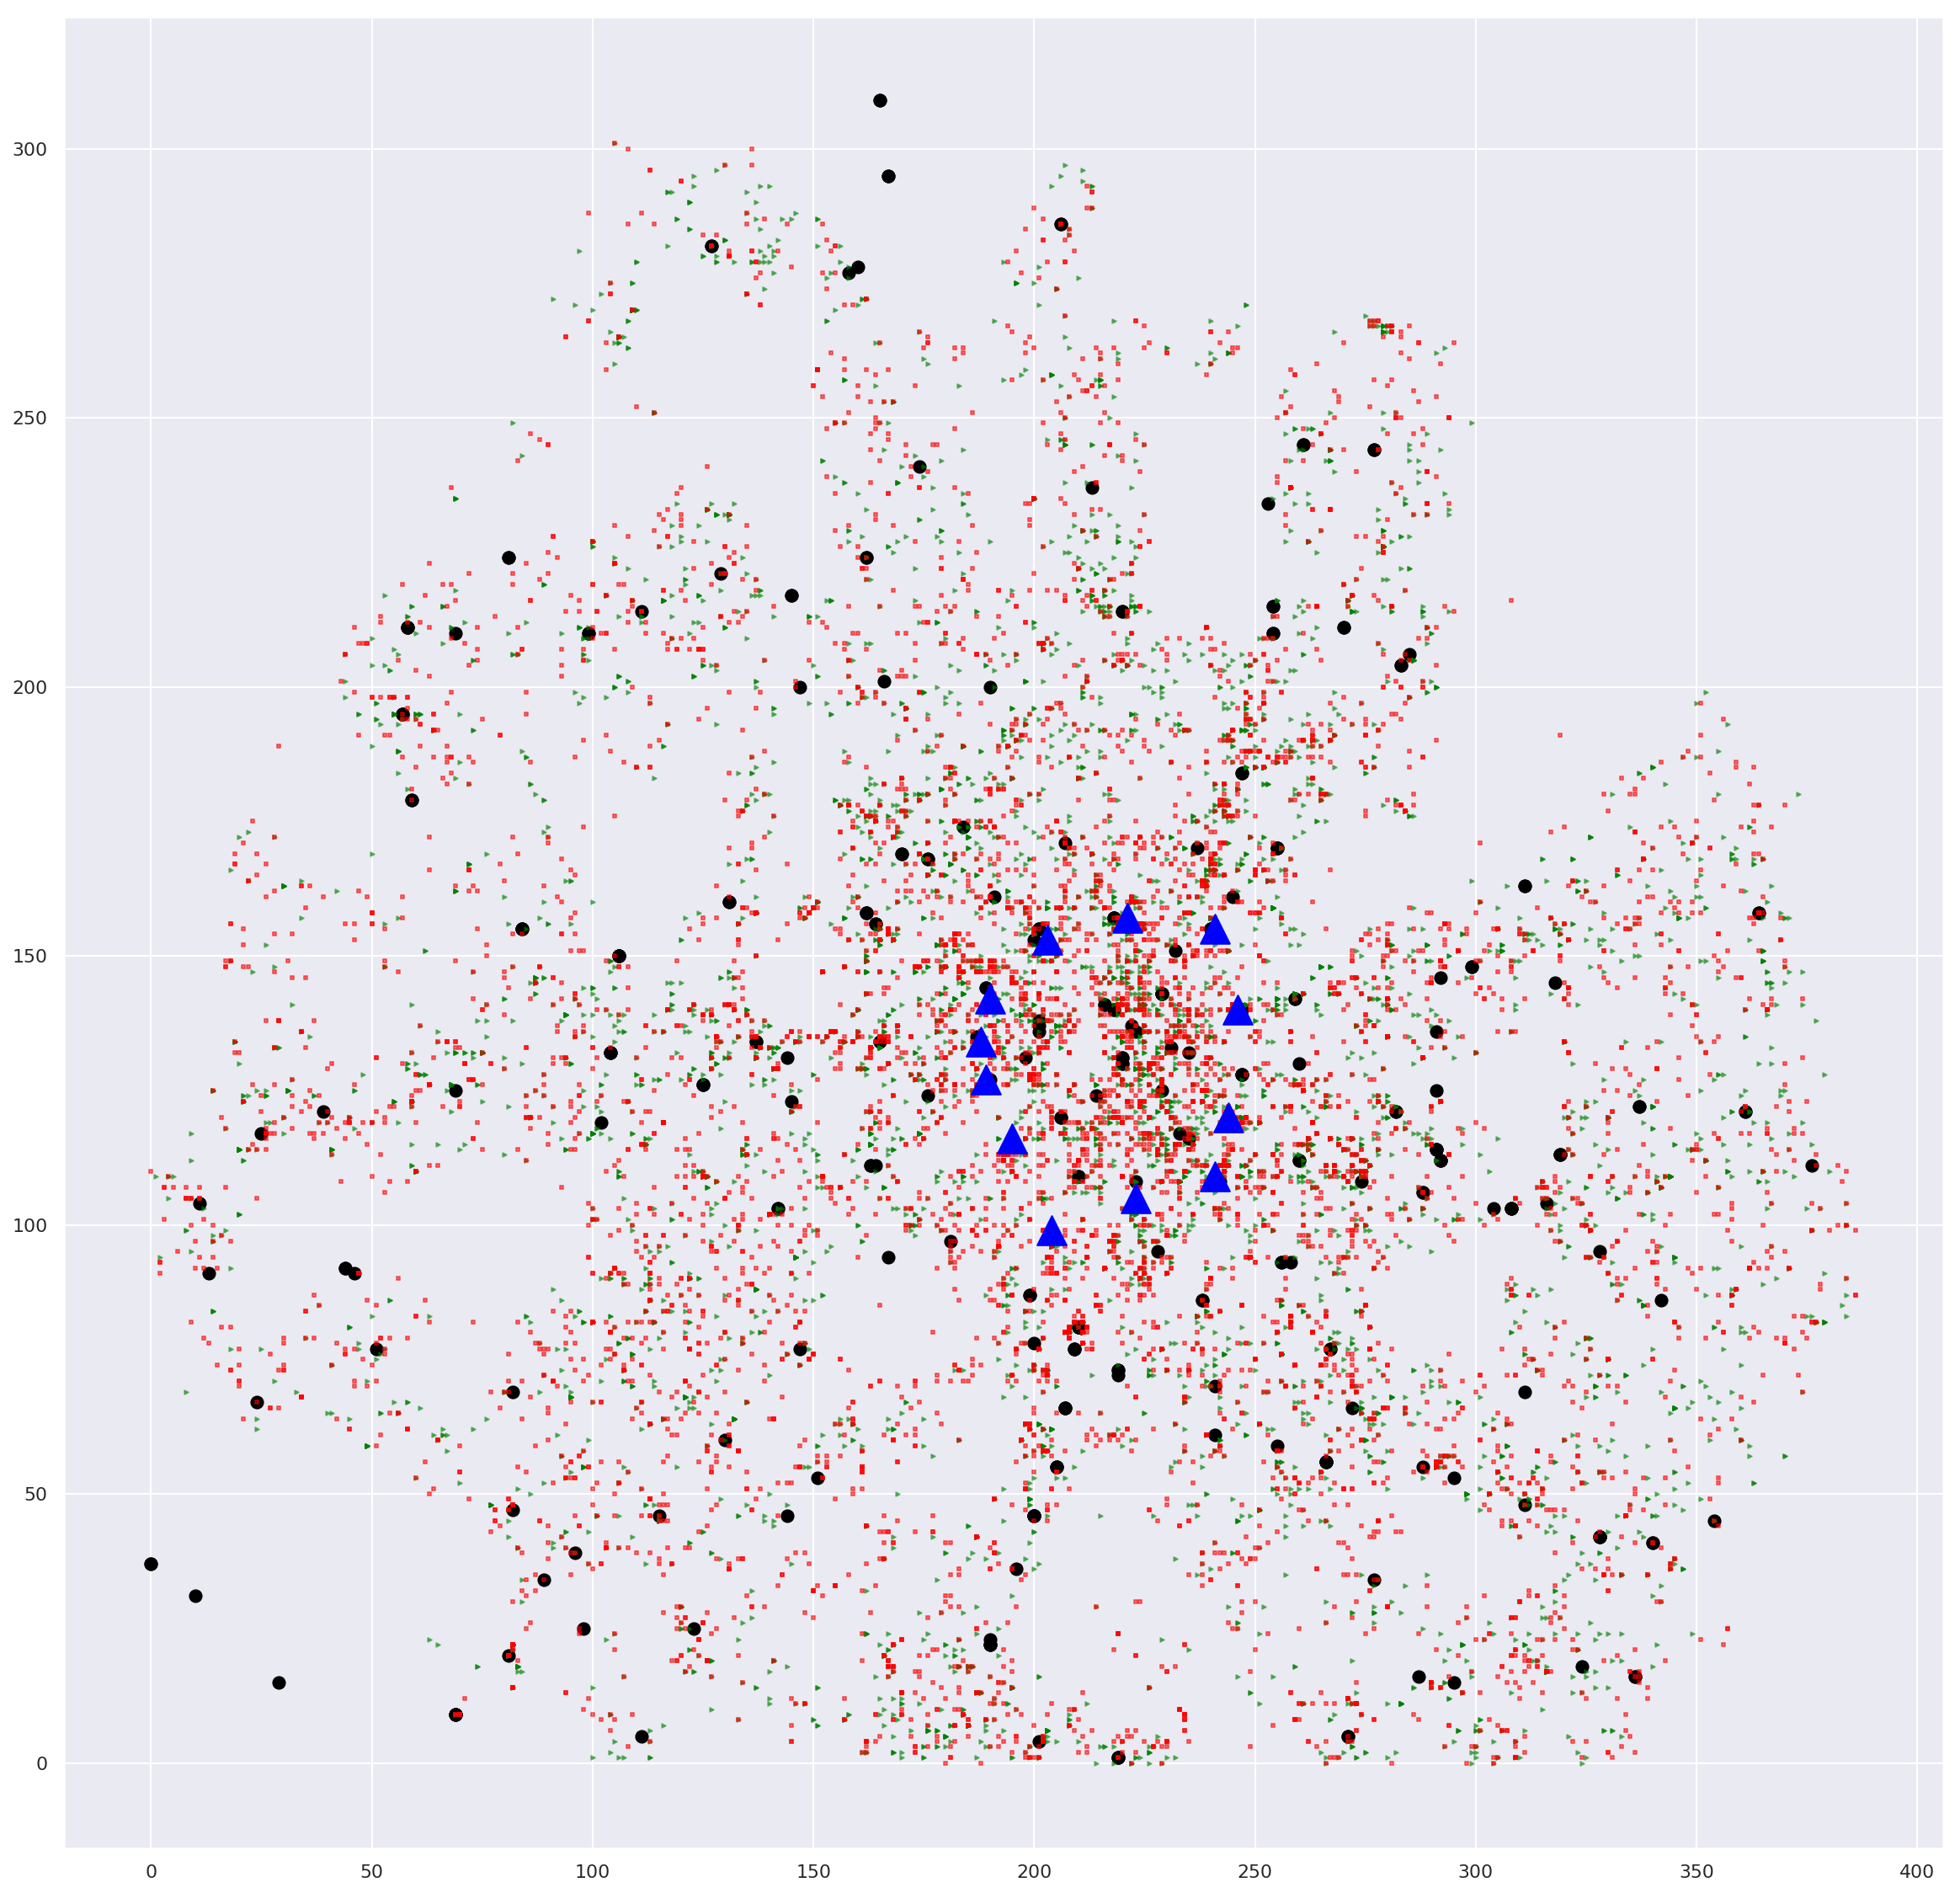

In [11]:
plot_data(couriers, depots, orders)

In [12]:
orders['distance'] = np.abs(orders['pickup_location_x'] - orders['dropoff_location_x'`s]) + np.abs(orders['pickup_location_y'] - orders['dropoff_location_y']) + 10

In [13]:
orders['price_per_min'] = orders['payment'] / orders['distance']

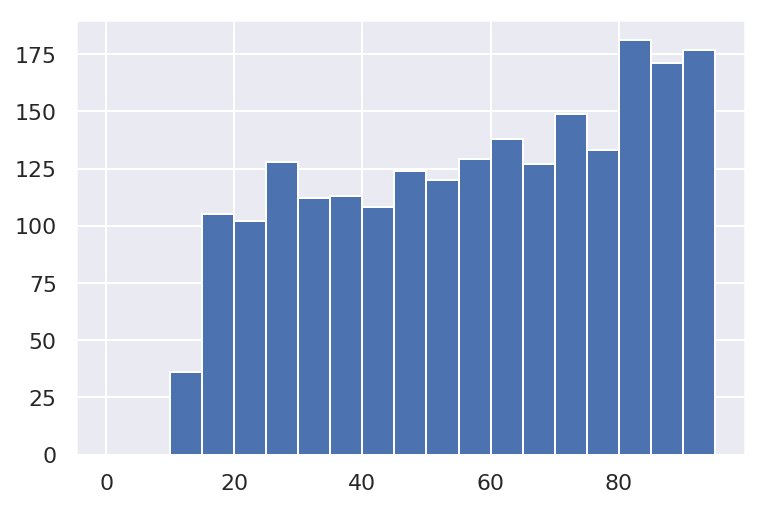

In [14]:
orders.distance.hist(bins=np.arange(0, 100, 5))

In [15]:
from sklearn.neighbors import NearestNeighbors

In [16]:
nn = NearestNeighbors(n_neighbors=1000, p=1)
nn.fit(orders[['pickup_location_x', 'pickup_location_y']])

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=1000, p=1,
         radius=1.0)

In [17]:
nearest_orders = nn.kneighbors(couriers[['location_x', 'location_y']])[1]

In [20]:
class Order:
    
    def __init__(self, order_data):
        self.pickup_x = order_data['pickup_location_x']
        self.pickup_y = order_data['pickup_location_y']
        self.pickup_from = order_data['pickup_from']
        self.pickup_from = order_data['pickup_to']
        self.dropoff_x = order_data['dropoff_location_x']
        self.dropoff_y = order_data['dropoff_location_y']
        self.dropoff_from = order_data['dropoff_from']
        self.dropoff_to = order_data['dropoff_to']
        self.payment = order_data['payment']
        self.distance = order_data['distance']
        self.price_per_min = order_data['price_per_min']
        
        

        
        
        

In [21]:
def distance(x1, y1, x2, y2):
    return abs(x1 - x2) + abs(y1 - y2) + 10

In [22]:
MAX = -99999999

In [23]:
def get_nearest_orders(x, y):
    return nn.kneighbors([[x, y]])[1][0]

In [24]:
all_orders = [Order(order) for order in orders.to_dict('records')]

In [32]:
def order_cost_fn(curr_x, curr_y, curr_time, order: Order):
    order_pickup_distance = distance(curr_x, curr_y, order.pickup_x, order.pickup_y)
    pickup_time = max(curr_time + order_pickup_distance, order.pickup_from)
    dropoff_time = max(pickup_time + order.distance, order.dropoff_from)
    # print(pickup_time, dropoff_time, order.dropoff_to)
    rv = MAX
    if dropoff_time > order.dropoff_to:
        rv = MAX
    
    else:
        rv = order.payment / (dropoff_time - curr_time)

        
    return rv, dropoff_time
    


def greedy(start_x, start_y, start_time, all_orders, amask):
    curr_x, curr_y, curr_time = start_x, start_y, start_time
    money = 0
    while True:
        nearest_orders = [order for order in get_nearest_orders(curr_x, curr_y) if not amask[order]]
        if not nearest_orders:
            break
        order_scores = [order_cost_fn(curr_x, curr_y, curr_time, all_orders[oid])[0] for oid in nearest_orders]
        min_score_id = np.argmax(order_scores)
        # print(max(order_scores))
        if max(order_scores) < 0:
            break
            
        best_order_id = nearest_orders[min_score_id]
        best_order = all_orders[best_order_id]
        amask[best_order_id] = 1
        # print(best_order_id)
        dropoff_time = order_cost_fn(curr_x, curr_y, curr_time, best_order)[1]
        money += best_order.payment
        curr_x, curr_y, curr_time = best_order.dropoff_x, best_order.dropoff_y, dropoff_time
        
    return money - 2 * (curr_time - start_time)
    
    

In [33]:
amask = np.zeros(len(all_orders))

In [34]:
import tqdm

In [35]:
couriers.head()

,courier_id,location_x,location_y
0,1,111,5
1,2,260,112
2,3,207,66
3,4,288,55
4,5,253,234


In [36]:
money = []
for start_x, start_y in tqdm.tqdm_notebook(zip(couriers.location_x, couriers.location_y)):
    money.append(greedy(start_x, start_y, 360, all_orders, amask))
    

In [38]:
sum(amask)

1392.0

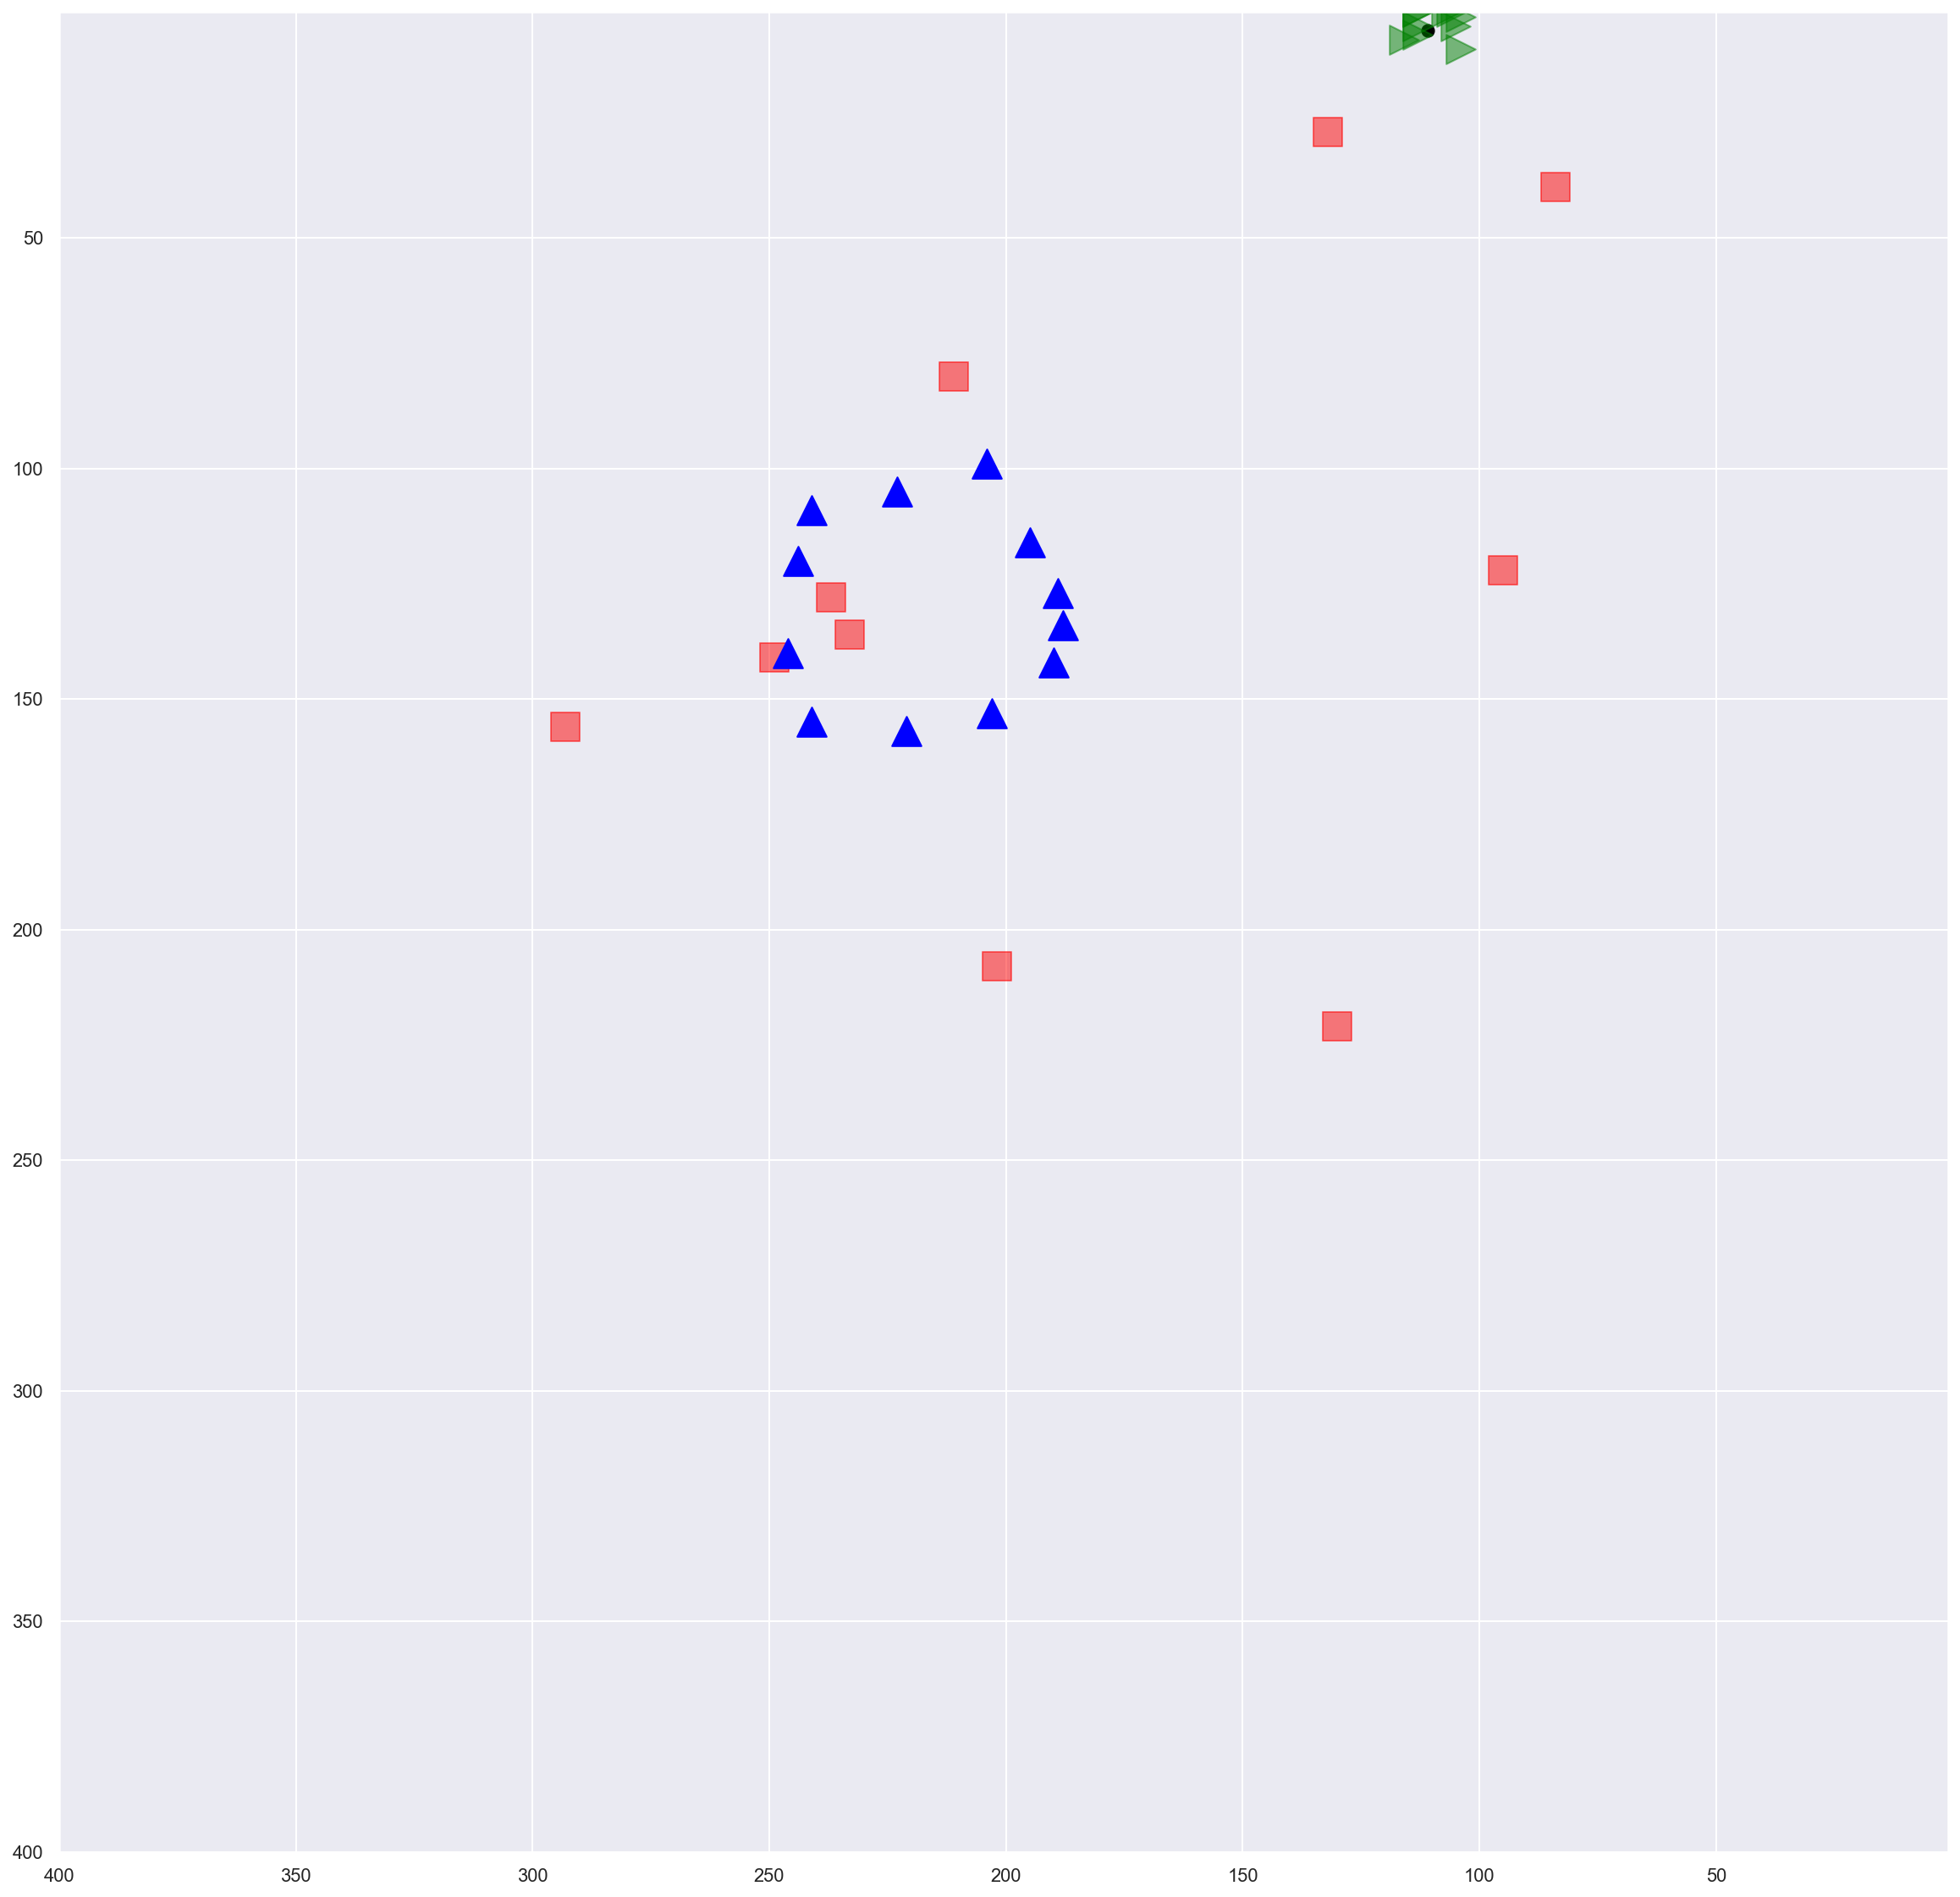

In [263]:
plot_data(couriers[:1], depots, orders, nearest_orders[0])